In [186]:
!pip install -q "tensorflow==2.11.*"
!pip install -q "tensorflow_io==0.28.*"


In [370]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import wave
import csv
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

In [65]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [94]:
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [1465]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])


In [1421]:
_ = tf.keras.utils.get_file('duck.zip',
                        'https://github.com/Boden448/Sound/archive/main.zip',
                        cache_dir='./',
                        cache_subdir='dataeassstart',
                        extract=True)

   8192/Unknown - 0s 0s/step

In [1422]:
meta_csv='./dataeassstart/Sound-main/meta/duck.csv'
base_data_path='./dataeassstart/Sound-main/audio/'


In [1423]:
pd_data = pd.read_csv(meta_csv)
pd_data.head()

,filename,fold,target,category
0,8duck.wav,1,0,duck
1,9duck.wav,1,0,duck
2,10duck.wav,1,0,duck
3,11duck.wav,1,0,duck
4,12duck.wav,1,0,duck


In [1424]:
my_classes = ['duck','cow','pig']
map_class_to_id = {'duck':0,'cow':1,'pig':2}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

,filename,fold,target,category
0,./dataeassstart/Sound-main/audio/8duck.wav,1,0,duck
1,./dataeassstart/Sound-main/audio/9duck.wav,1,0,duck
2,./dataeassstart/Sound-main/audio/10duck.wav,1,0,duck
3,./dataeassstart/Sound-main/audio/11duck.wav,1,0,duck
4,./dataeassstart/Sound-main/audio/12duck.wav,1,0,duck
5,./dataeassstart/Sound-main/audio/13duck.wav,1,0,duck
6,./dataeassstart/Sound-main/audio/14duck.wav,1,0,duck
7,./dataeassstart/Sound-main/audio/15duck.wav,1,0,duck
8,./dataeassstart/Sound-main/audio/16duck.wav,1,0,duck
9,./dataeassstart/Sound-main/audio/17duck.wav,1,0,duck


In [1425]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [1426]:
def load_wav_for_map(filename, label, fold):
    return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [1427]:
def extract_embedding(wav_data, label, fold):
    ''' run YAMNet to extract embedding from the wav data '''
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [1428]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(64).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(64).prefetch(tf.data.AUTOTUNE)

In [1429]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float64,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='softmax'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_166 (Dense)           (None, 512)               524800    
                                                                 
 dense_167 (Dense)           (None, 3)                 1539      
                                                                 
Total params: 526,339
Trainable params: 526,339
Non-trainable params: 0
_________________________________________________________________


In [1430]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])


callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [1433]:
for i in range(1):
    history = my_model.fit(train_ds,
                       epochs=1000,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/1000
13/13 [==============================] - 0s 35ms/step - loss: 0.5098 - accuracy: 0.9891
Epoch 2/1000
13/13 [==============================] - 0s 35ms/step - loss: 0.4969 - accuracy: 0.9928
Epoch 3/1000
13/13 [==============================] - 0s 34ms/step - loss: 0.4846 - accuracy: 0.9940
Epoch 4/1000
13/13 [==============================] - 0s 34ms/step - loss: 0.4729 - accuracy: 0.9952
Epoch 5/1000
13/13 [==============================] - 0s 33ms/step - loss: 0.4618 - accuracy: 0.9952
Epoch 6/1000
13/13 [==============================] - 0s 34ms/step - loss: 0.4510 - accuracy: 0.9964
Epoch 7/1000
13/13 [==============================] - 0s 34ms/step - loss: 0.4407 - accuracy: 0.9964
Epoch 8/1000
13/13 [==============================] - 0s 34ms/step - loss: 0.4310 - accuracy: 0.9964
Epoch 9/1000
13/13 [==============================] - 0s 33ms/step - loss: 0.4216 - accuracy: 0.9976
Epoch 10/1000
13/13 [==============================] - 0s 34ms/step - loss: 0.4123 - accura

13/13 [==============================] - 1s 102ms/step - loss: 0.1290 - accuracy: 1.0000
Epoch 82/1000
13/13 [==============================] - 1s 107ms/step - loss: 0.1273 - accuracy: 1.0000
Epoch 83/1000
13/13 [==============================] - 1s 90ms/step - loss: 0.1257 - accuracy: 1.0000
Epoch 84/1000
13/13 [==============================] - 1s 95ms/step - loss: 0.1241 - accuracy: 1.0000
Epoch 85/1000
13/13 [==============================] - 1s 85ms/step - loss: 0.1225 - accuracy: 1.0000
Epoch 86/1000
13/13 [==============================] - 1s 78ms/step - loss: 0.1209 - accuracy: 1.0000
Epoch 87/1000
13/13 [==============================] - 1s 84ms/step - loss: 0.1194 - accuracy: 1.0000
Epoch 88/1000
13/13 [==============================] - 1s 83ms/step - loss: 0.1179 - accuracy: 1.0000
Epoch 89/1000
13/13 [==============================] - 1s 84ms/step - loss: 0.1164 - accuracy: 1.0000
Epoch 90/1000
13/13 [==============================] - 1s 89ms/step - loss: 0.1150 - accuracy:

13/13 [==============================] - 1s 56ms/step - loss: 0.0537 - accuracy: 1.0000
Epoch 161/1000
13/13 [==============================] - 1s 57ms/step - loss: 0.0531 - accuracy: 1.0000
Epoch 162/1000
13/13 [==============================] - 1s 55ms/step - loss: 0.0526 - accuracy: 1.0000
Epoch 163/1000
13/13 [==============================] - 1s 57ms/step - loss: 0.0521 - accuracy: 1.0000
Epoch 164/1000
13/13 [==============================] - 1s 53ms/step - loss: 0.0516 - accuracy: 1.0000
Epoch 165/1000
13/13 [==============================] - 1s 55ms/step - loss: 0.0512 - accuracy: 1.0000
Epoch 166/1000
13/13 [==============================] - 1s 52ms/step - loss: 0.0507 - accuracy: 1.0000
Epoch 167/1000
13/13 [==============================] - 1s 53ms/step - loss: 0.0502 - accuracy: 1.0000
Epoch 168/1000
13/13 [==============================] - 1s 57ms/step - loss: 0.0497 - accuracy: 1.0000
Epoch 169/1000
13/13 [==============================] - 1s 56ms/step - loss: 0.0493 - ac

13/13 [==============================] - 1s 54ms/step - loss: 0.0270 - accuracy: 1.0000
Epoch 240/1000
13/13 [==============================] - 1s 73ms/step - loss: 0.0267 - accuracy: 1.0000
Epoch 241/1000
13/13 [==============================] - 1s 50ms/step - loss: 0.0265 - accuracy: 1.0000
Epoch 242/1000
13/13 [==============================] - 1s 56ms/step - loss: 0.0263 - accuracy: 1.0000
Epoch 243/1000
13/13 [==============================] - 1s 57ms/step - loss: 0.0261 - accuracy: 1.0000
Epoch 244/1000
13/13 [==============================] - 1s 53ms/step - loss: 0.0259 - accuracy: 1.0000
Epoch 245/1000
13/13 [==============================] - 1s 56ms/step - loss: 0.0257 - accuracy: 1.0000
Epoch 246/1000
13/13 [==============================] - 1s 55ms/step - loss: 0.0255 - accuracy: 1.0000
Epoch 247/1000
13/13 [==============================] - 1s 55ms/step - loss: 0.0253 - accuracy: 1.0000
Epoch 248/1000
13/13 [==============================] - 1s 57ms/step - loss: 0.0251 - ac

13/13 [==============================] - 1s 76ms/step - loss: 0.0148 - accuracy: 1.0000
Epoch 319/1000
13/13 [==============================] - 1s 65ms/step - loss: 0.0147 - accuracy: 1.0000
Epoch 320/1000
13/13 [==============================] - 1s 60ms/step - loss: 0.0146 - accuracy: 1.0000
Epoch 321/1000
13/13 [==============================] - 1s 54ms/step - loss: 0.0145 - accuracy: 1.0000
Epoch 322/1000
13/13 [==============================] - 1s 58ms/step - loss: 0.0144 - accuracy: 1.0000
Epoch 323/1000
13/13 [==============================] - 1s 58ms/step - loss: 0.0143 - accuracy: 1.0000
Epoch 324/1000
13/13 [==============================] - 1s 57ms/step - loss: 0.0142 - accuracy: 1.0000
Epoch 325/1000
13/13 [==============================] - 1s 57ms/step - loss: 0.0141 - accuracy: 1.0000
Epoch 326/1000
13/13 [==============================] - 1s 58ms/step - loss: 0.0140 - accuracy: 1.0000
Epoch 327/1000
13/13 [==============================] - 1s 56ms/step - loss: 0.0139 - ac

13/13 [==============================] - 1s 59ms/step - loss: 0.0086 - accuracy: 1.0000
Epoch 398/1000
13/13 [==============================] - 1s 51ms/step - loss: 0.0085 - accuracy: 1.0000
Epoch 399/1000
13/13 [==============================] - 1s 53ms/step - loss: 0.0084 - accuracy: 1.0000
Epoch 400/1000
13/13 [==============================] - 1s 57ms/step - loss: 0.0084 - accuracy: 1.0000
Epoch 401/1000
13/13 [==============================] - 1s 54ms/step - loss: 0.0083 - accuracy: 1.0000
Epoch 402/1000
13/13 [==============================] - 1s 57ms/step - loss: 0.0083 - accuracy: 1.0000
Epoch 403/1000
13/13 [==============================] - 1s 58ms/step - loss: 0.0082 - accuracy: 1.0000
Epoch 404/1000
13/13 [==============================] - 1s 61ms/step - loss: 0.0082 - accuracy: 1.0000
Epoch 405/1000
13/13 [==============================] - 1s 56ms/step - loss: 0.0081 - accuracy: 1.0000
Epoch 406/1000
13/13 [==============================] - 1s 53ms/step - loss: 0.0081 - ac

13/13 [==============================] - 1s 76ms/step - loss: 0.0051 - accuracy: 1.0000
Epoch 477/1000
13/13 [==============================] - 1s 63ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 478/1000
13/13 [==============================] - 1s 69ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 479/1000
13/13 [==============================] - 1s 67ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 480/1000
13/13 [==============================] - 1s 62ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 481/1000
13/13 [==============================] - 1s 64ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 482/1000
13/13 [==============================] - 1s 62ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 483/1000
13/13 [==============================] - 1s 62ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 484/1000
13/13 [==============================] - 1s 56ms/step - loss: 0.0048 - accuracy: 1.0000
Epoch 485/1000
13/13 [==============================] - 1s 57ms/step - loss: 0.0048 - ac

13/13 [==============================] - 1s 52ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 556/1000
13/13 [==============================] - 1s 54ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 557/1000
13/13 [==============================] - 1s 57ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 558/1000
13/13 [==============================] - 1s 55ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 559/1000
13/13 [==============================] - 1s 52ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 560/1000
13/13 [==============================] - 1s 58ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 561/1000
13/13 [==============================] - 1s 52ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 562/1000
13/13 [==============================] - 1s 56ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 563/1000
13/13 [==============================] - 1s 54ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 564/1000
13/13 [==============================] - 1s 55ms/step - loss: 0.0029 - ac

13/13 [==============================] - 1s 55ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 635/1000
13/13 [==============================] - 1s 52ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 636/1000
13/13 [==============================] - 1s 54ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 637/1000
13/13 [==============================] - 1s 52ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 638/1000
13/13 [==============================] - 1s 63ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 639/1000
13/13 [==============================] - 1s 58ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 640/1000
13/13 [==============================] - 1s 53ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 641/1000
13/13 [==============================] - 1s 52ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 642/1000
13/13 [==============================] - 1s 56ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 643/1000
13/13 [==============================] - 1s 56ms/step - loss: 0.0018 - ac

13/13 [==============================] - 1s 55ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 714/1000
13/13 [==============================] - 1s 50ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 715/1000
13/13 [==============================] - 1s 57ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 716/1000
13/13 [==============================] - 1s 53ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 717/1000
13/13 [==============================] - 1s 59ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 718/1000
13/13 [==============================] - 1s 56ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 719/1000
13/13 [==============================] - 1s 55ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 720/1000
13/13 [==============================] - 1s 54ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 721/1000
13/13 [==============================] - 1s 56ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 722/1000
13/13 [==============================] - 1s 50ms/step - loss: 0.0011 - ac

13/13 [==============================] - 1s 58ms/step - loss: 7.0544e-04 - accuracy: 1.0000
Epoch 791/1000
13/13 [==============================] - 1s 54ms/step - loss: 7.0110e-04 - accuracy: 1.0000
Epoch 792/1000
13/13 [==============================] - 1s 56ms/step - loss: 6.9681e-04 - accuracy: 1.0000
Epoch 793/1000
13/13 [==============================] - 1s 54ms/step - loss: 6.9248e-04 - accuracy: 1.0000
Epoch 794/1000
13/13 [==============================] - 1s 49ms/step - loss: 6.8824e-04 - accuracy: 1.0000
Epoch 795/1000
13/13 [==============================] - 1s 53ms/step - loss: 6.8398e-04 - accuracy: 1.0000
Epoch 796/1000
13/13 [==============================] - 1s 54ms/step - loss: 6.7980e-04 - accuracy: 1.0000
Epoch 797/1000
13/13 [==============================] - 1s 55ms/step - loss: 6.7561e-04 - accuracy: 1.0000
Epoch 798/1000
13/13 [==============================] - 1s 54ms/step - loss: 6.7144e-04 - accuracy: 1.0000
Epoch 799/1000
13/13 [==============================

13/13 [==============================] - 1s 56ms/step - loss: 4.4150e-04 - accuracy: 1.0000
Epoch 867/1000
13/13 [==============================] - 1s 55ms/step - loss: 4.3879e-04 - accuracy: 1.0000
Epoch 868/1000
13/13 [==============================] - 1s 56ms/step - loss: 4.3610e-04 - accuracy: 1.0000
Epoch 869/1000
13/13 [==============================] - 1s 54ms/step - loss: 4.3341e-04 - accuracy: 1.0000
Epoch 870/1000
13/13 [==============================] - 1s 60ms/step - loss: 4.3077e-04 - accuracy: 1.0000
Epoch 871/1000
13/13 [==============================] - 1s 59ms/step - loss: 4.2811e-04 - accuracy: 1.0000
Epoch 872/1000
13/13 [==============================] - 1s 51ms/step - loss: 4.2549e-04 - accuracy: 1.0000
Epoch 873/1000
13/13 [==============================] - 1s 51ms/step - loss: 4.2288e-04 - accuracy: 1.0000
Epoch 874/1000
13/13 [==============================] - 1s 54ms/step - loss: 4.2029e-04 - accuracy: 1.0000
Epoch 875/1000
13/13 [==============================

13/13 [==============================] - 1s 57ms/step - loss: 2.7663e-04 - accuracy: 1.0000
Epoch 943/1000
13/13 [==============================] - 1s 55ms/step - loss: 2.7493e-04 - accuracy: 1.0000
Epoch 944/1000
13/13 [==============================] - 1s 53ms/step - loss: 2.7325e-04 - accuracy: 1.0000
Epoch 945/1000
13/13 [==============================] - 1s 53ms/step - loss: 2.7156e-04 - accuracy: 1.0000
Epoch 946/1000
13/13 [==============================] - 1s 64ms/step - loss: 2.6990e-04 - accuracy: 1.0000
Epoch 947/1000
13/13 [==============================] - 1s 53ms/step - loss: 2.6825e-04 - accuracy: 1.0000
Epoch 948/1000
13/13 [==============================] - 1s 62ms/step - loss: 2.6663e-04 - accuracy: 1.0000
Epoch 949/1000
13/13 [==============================] - 1s 52ms/step - loss: 2.6498e-04 - accuracy: 1.0000
Epoch 950/1000
13/13 [==============================] - 1s 58ms/step - loss: 2.6335e-04 - accuracy: 1.0000
Epoch 951/1000
13/13 [==============================

In [1434]:
class ReduceMeanLayer(tf.keras.layers.Layer):
    def __init__(self, axis=0, **kwargs):
        super(ReduceMeanLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, input):
        return tf.math.reduce_mean(input, axis=self.axis)

In [1435]:
testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')

print(testing_wav_file_name)

testing_wav_data = load_wav_16k_mono(testing_wav_file_name)


./test_data\miaow_16k.wav


In [1436]:
class ReduceMeanLayer(tf.keras.layers.Layer):
    def __init__(self, axis=0, **kwargs):
        super(ReduceMeanLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, input):
        return tf.math.reduce_mean(input, axis=self.axis)

./dataeassstart/Sound-main/audio/1pig.wav


Waveform values: [-5.5530812e-08  1.4851365e-07 -9.7934238e-09 ... -1.6815387e-02
 -1.7332396e-02 -1.0816258e-02]


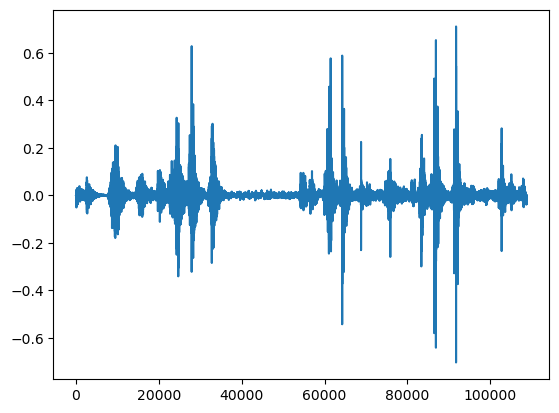

In [1463]:
test_pd = filtered_pd.loc[filtered_pd['fold'] == 1]
row = test_pd.sample(1)
filename = row['filename'].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [1464]:
reloaded_results = reloaded_model(waveform)
your_top_class = tf.math.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Your model] The main sound is: {your_inferred_class} ({your_top_score})')

[Your model] The main sound is: cow (0.9237446188926697)
